In [3]:
## Demarrage du projet ##
1+1 #Ca porte chance

2

In [4]:
from Data import DataLoader
from Data import RadarDataSet
from PreProcessing.domaines.passage_freq import get_signal_frequentiel
from Models.PolynomialRegressor import PolynomialRegressor
from Models.BasicNNModel import BasicNNModel
from Models.BasicCNNModel import BasicCNNModel
from Models.BasicAutoEncoder import BasicAutoEncoder
from PreProcessing.utils import data_to_complex
from sklearn.preprocessing import StandardScaler
from Evaluation.plots import ErrorOfSNRPlot 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Chargement des données

In [6]:
## Chargement des données
data_loader = DataLoader.DataLoader("./Data/Dataset_X5717_SNR.csv","./Data/Dataset_y5717_SNR.csv")
data, labels = data_loader.load_data()
radar_dataset = RadarDataSet.RadarDataSet(data,labels,0.4, StandardScaler(),appended_snr=True) #0.2 is the test size ( 80% train data, 20% test data)
radar_dataset.add_frequential_data()
radar_dataset.y_test.shape

(12134, 181)

# Chargement de différents modèles

In [7]:
basicCNNModel = BasicCNNModel()
basicCNNModel.load("CNNzarrouk_bcross_b50_e30_sigmoid_adam")

#basicAutoEncoder = BasicAutoEncoder()
#basicAutoEncoder.load("basicAutoEncoder")
#X_test_encoded = basicAutoEncoder.encode(radar_dataset.X_test).squeeze()

# Prediction des données de test + évaluation

380/380 [==============================] - 10s 26ms/step
LES METRIQUES SUIVANTES SONT CALCULEES APRES AVOIR TRANSFORMER LES DONNEES DE SORTIES EN SORTIES BINAIRE AVEC UN SEUIL DE 0.45
Mean square error: 0.0023512763095707508
Root Mean square error: 0.04848996091533536
R2 Score : 0.91590569656736
Accuracy 0.9052265399626676


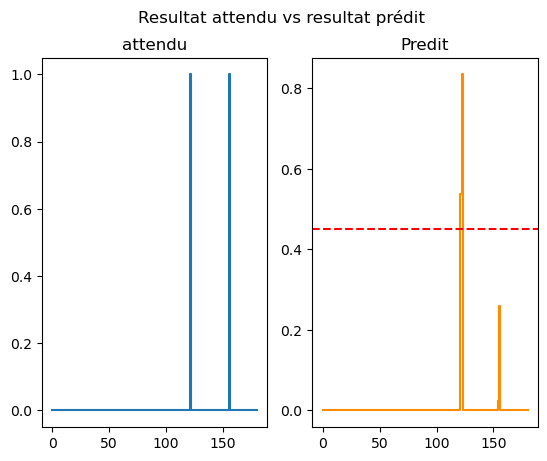

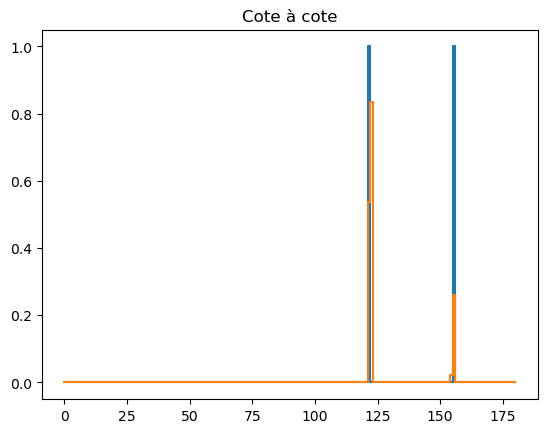

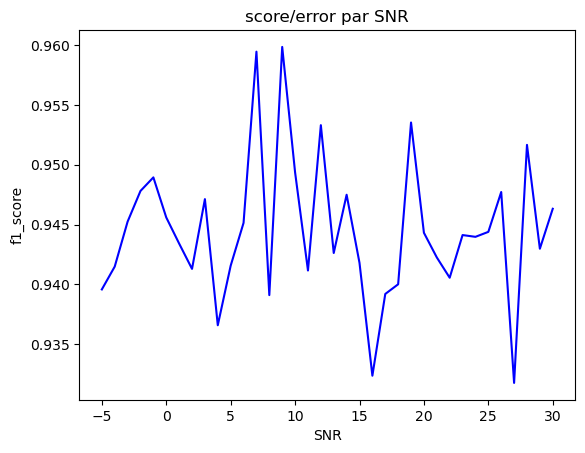

In [8]:
from Evaluation.plots import PredictedStepPlot, LearningCurvesPlot
from Evaluation.statistic_errors import MSEEvaluateur, RMSEEvaluateur, R2Score, Accuracy

threshold = 0.45
radar_dataset.X_test = data_to_complex(radar_dataset.X_test)# pour concatener reel et imaginaire
y_predicted = basicCNNModel.model.predict(radar_dataset.X_test)


randomTestIndex = random.randint(0, len(y_predicted))
PredictedStepPlot().evaluate(
    radar_dataset.y_test[randomTestIndex], y_predicted[randomTestIndex], threshold = threshold
)

y_test_pred_binary = (y_predicted > threshold).astype(int)
print("LES METRIQUES SUIVANTES SONT CALCULEES APRES AVOIR TRANSFORMER LES DONNEES DE SORTIES EN SORTIES BINAIRE AVEC UN SEUIL DE "+str(threshold))
MSEEvaluateur().evaluate(radar_dataset.y_test, y_test_pred_binary)
RMSEEvaluateur().evaluate(radar_dataset.y_test, y_test_pred_binary)
R2Score().evaluate(radar_dataset.y_test, y_test_pred_binary)
Accuracy().evaluate(radar_dataset.y_test, y_test_pred_binary)
plt.figure()
ErrorOfSNRPlot().evaluate(radar_dataset.snr_y_test, radar_dataset.y_test, y_test_pred_binary)

#POLYNOMIAL REGRESSION

polynomialRegressor = PolynomialRegressor()
polynomialRegressor.train(radar_dataset.X_train,radar_dataset.y_train)
polynomialRegressor.evaluate(radar_dataset.X_test,radar_dataset.y_test)


## Evaluation sur des données classées par SNR

In [77]:
from sklearn.metrics import f1_score
data_loader2 = DataLoader.DataLoader("./Data/Dataset_X4184_SNR-3030.csv","./Data/Dataset_y4184_SNR-3030.csv")
data2, labels2 = data_loader2.load_data()
radar_dataset2 = RadarDataSet.RadarDataSet(data2,labels2,0.4, StandardScaler(),appended_snr=True)
radar_dataset2.X = data_to_complex(radar_dataset2.X)# pour concatener reel et imaginaire
threshold = 0.45
y_predicted2 = basicCNNModel.model.predict(radar_dataset2.X)
y_predicted_binary2 = (y_predicted2> threshold).astype(int)




1144/1144 [==============================] - 30s 26ms/step


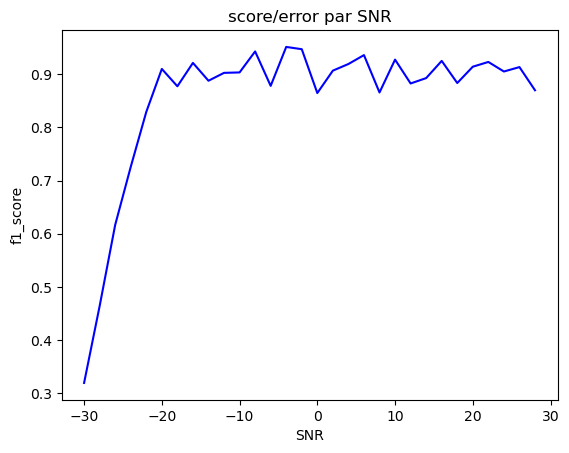

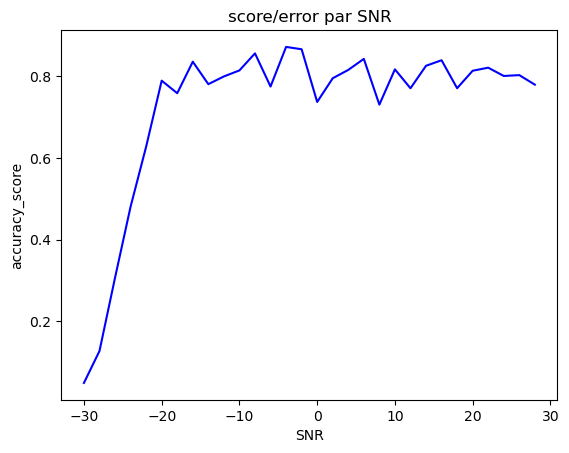

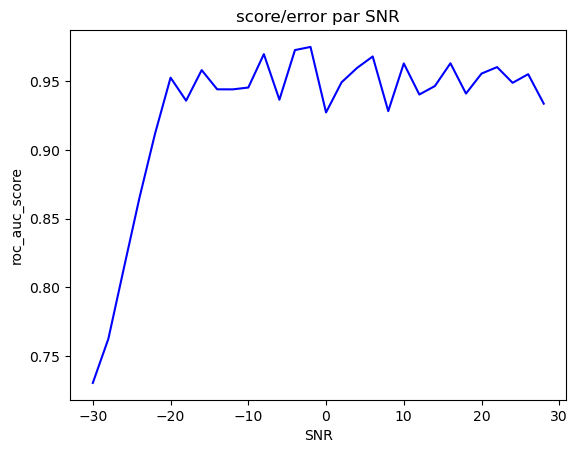

Accuracy 0.7903496627095178


0.7903496627095178

In [78]:
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2)
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2, errorFunc="accuracy_score")
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2, errorFunc="roc_auc_score")
Accuracy().evaluate(radar_dataset2.y, y_predicted_binary2)

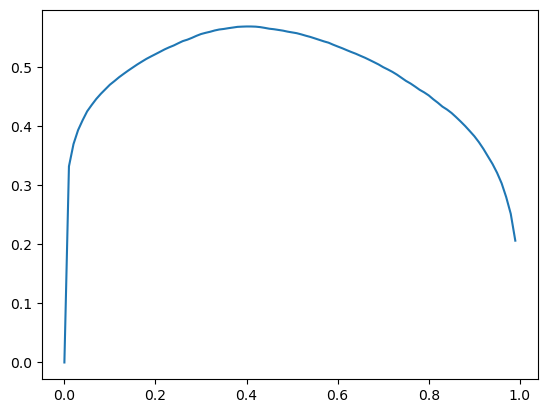

In [11]:
from sklearn.metrics import accuracy_score
TRESHOLDArray= np.arange(0,1,0.01)
accuracyOfTreshold = [accuracy_score(radar_dataset2.y, (y_predicted2> tresh).astype(int)) for tresh in TRESHOLDArray]
rmse_values = df.groupby('SNR').apply(lambda group: np.sqrt(
accuracy_score(np.array(group['y_true'].tolist()), np.array(group['y_pred'].tolist()))))
plt.plot(TRESHOLDArray,accuracyOfTreshold)

In [12]:
f1_score(radar_dataset2.y,(y_predicted2> threshold).astype(int),average='micro')

0.7606276666619418

In [13]:
accuracyOfTreshold.index(max(accuracyOfTreshold))

40

In [14]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix 
conf_matrices = multilabel_confusion_matrix(radar_dataset2.y, y_predicted_binary2)
conf_matrix_global = np.sum(conf_matrices, axis=0)

In [15]:
conf_matrix_global

array([[6537166,   14234],
       [  19540,   53660]], dtype=int64)

In [90]:
XX = np.array(pd.read_csv("./Data/Dataset_X5458_SNR.csv"))
yy = np.array(pd.read_csv("./Data/Dataset_y5458_SNR.csv"))

r = [np.max(yy[:,i]) for i in range(180)]

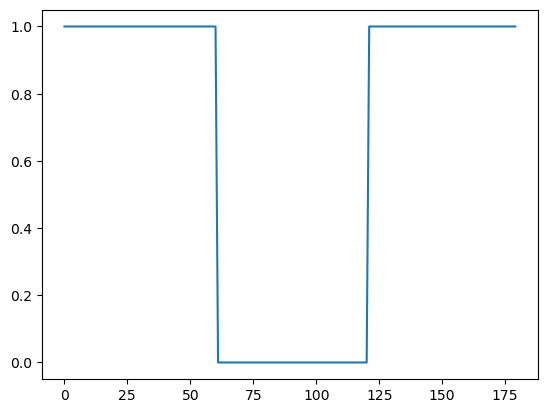

In [91]:
plt.plot(r)

In [87]:
yy.shape

(180, 3098)

In [82]:
yy[0][-1]

-5.0

In [95]:
radar_dataset2.y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])